In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
sns.set()
from tqdm import tqdm_notebook

# Problem 1

In [2]:
def simulate_bivariate(rho, N, mean=[0, 0], var=[1, 1]):
    return np.random.multivariate_normal(mean=mean, cov=[[var[0], rho], [rho, var[1]]], size=N)

def MME_est(data):
    return np.sum(np.multiply(data[:, 0], data[:, 1]))/len(data)

def MLE_eq(rho, data):
    n=len(data)
    return  -n*rho**3+rho**2*n*MME_est(data)\
            +n*rho*(1-np.sum(np.power(data[:,0],2)+np.power(data[:,1],2))/n)\
            +n*MME_est(data)
        
def MLE_est(data, init=10**(-5)):
    est=optimize.fsolve(MLE_eq, init, data)
    assert(len(est)==1)
    return est[0]

Method of Moments Estimation: 0.6998625734165653
Maximum Likelihood Estimation: 0.7000919187519035


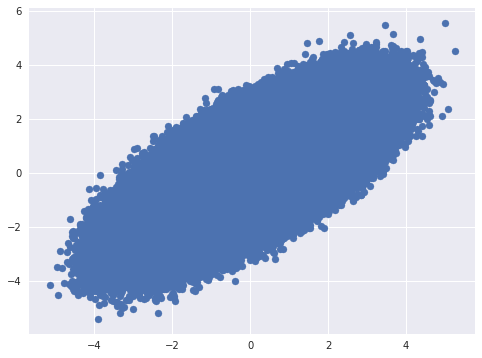

In [113]:
Sample=simulate_bivariate(0.7, 10000000)
plt.figure(figsize=[8, 6])
plt.scatter(Sample[:, 0], Sample[:, 1])
print('Method of Moments Estimation: {}'.format(MME_est(Sample)))
print('Maximum Likelihood Estimation: {}'.format(MLE_est(Sample)))

For a very large $N$ of 10 millions MLE and MME differ.

In [3]:
def simulate_many(rho, S, N, step):
    plt.figure(figsize=[12, 8])
    MME=[]
    MLE=[]
    for i in range(S, N+1, step):
        data=simulate_bivariate(rho, i)
        MME.append(MME_est(data))
        MLE.append(MLE_est(data))
    plt.plot([S, N], [rho, rho], color='red')
    rng=list(range(S, N+1, step))
    plt.plot(rng, MME, color='g', label='MME')
    plt.plot(rng, MLE, color='m', label='MLE')
    plt.legend()

Let's look at the MMEs and MLEs for different $N$.

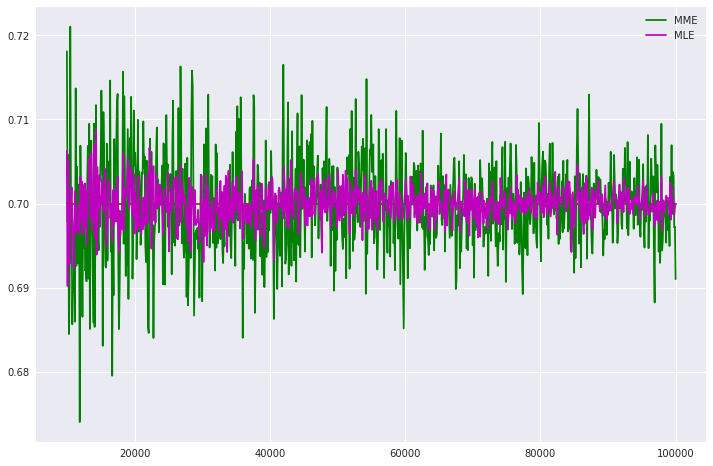

In [114]:
simulate_many(0.7, 10000, 100000, 100)

At a higher resolution:

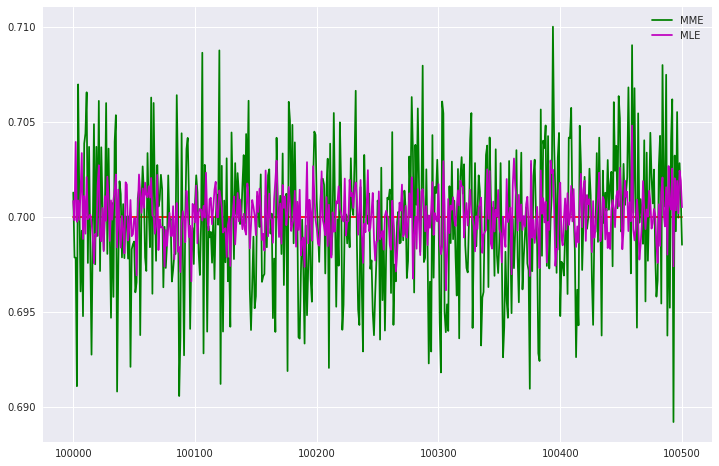

In [112]:
simulate_many(0.7, 100000, 100500, 1)

In [4]:
def simulate_many2(rho, S, N, step):
    plt.figure(figsize=[12, 8])
    ratio=[]
    for i in range(S, N+1, step):
        data=simulate_bivariate(rho, i)
        ratio.append(MLE_est(data)/MME_est(data))
    plt.plot([S, N], [1, 1], color='red')
    rng=list(range(S, N+1, step))
    plt.plot(rng, ratio, color='m')

Whether $\frac{MLE}{MME}$ is 1:

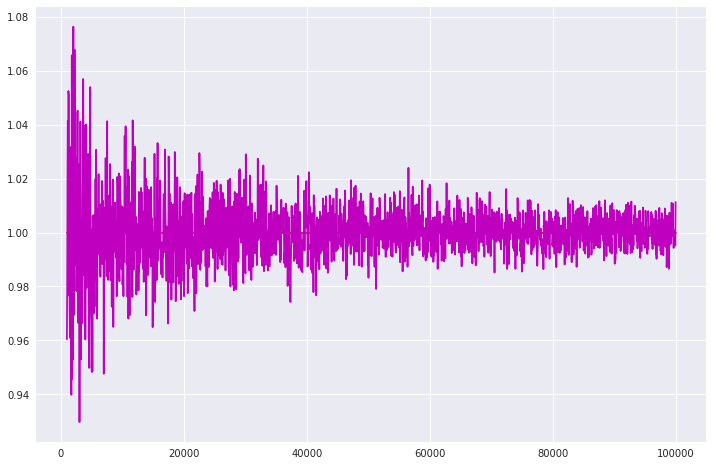

In [7]:
simulate_many2(0.7, 1000, 100000, 50)

Seems that the quotient of two estimations just keeps oscilating.

### Checking whether MLE is biased

In [7]:
def MLE_expectation(rho, N, iters):
    summ=0
    for i in tqdm_notebook(range(iters)):
        data=simulate_bivariate(rho, N)
        summ+=MLE_est(data)
    return summ/iters

def bias_plot():
    pass

In [10]:
MLE_expectation(0.35, 1000, 100000)

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

0.34995304767999963

Seems that MLE is unbiased.

### Checking whether MLE estimation reach Cramer-Rao lower bound
$D\hat{\rho}\geq\frac{(1-\rho^2)^2}{n(\rho^2+1)}$

In [30]:
def lower_bound(rho, n):
    return (1-rho**2)**2/(n*(rho**2+1))

In [49]:
def bounds_plot(rho, S, N, step, per_it=1000):
    from itertools import product
    plt.figure(figsize=[12, 8])
    var=[]
    lb=[]
    for i in tqdm_notebook(range(S, N+1, step)):
        MLE=[]
        for j in range(per_it):
            data=simulate_bivariate(rho, i)
            MLE.append(MLE_est(data))
        var.append(np.var(MLE))
        lb.append(lower_bound(rho, i))
    rng=list(range(S, N+1, step))
    plt.plot(rng, lb, color='m')
    plt.xlabel('N samples')
    plt.ylabel('Variance')
    plt.plot(rng, var, color='b')

HBox(children=(IntProgress(value=0, max=181), HTML(value='')))

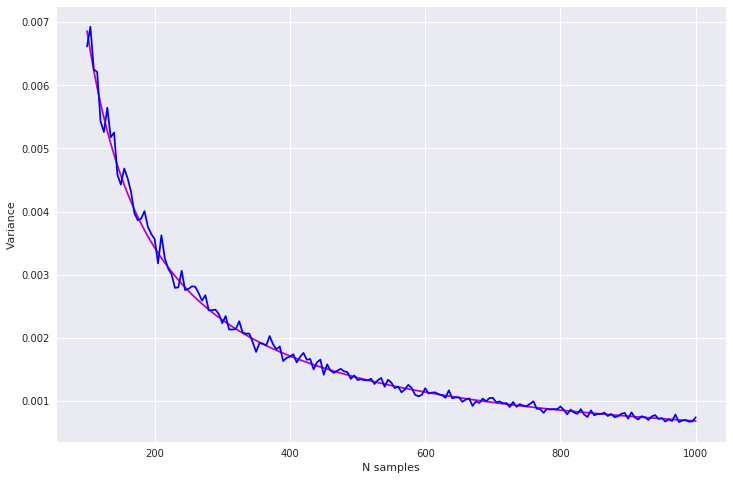

In [50]:
bounds_plot(0.35, 100, 1000, 5)

Seems that MLE estimation reaches Cramer-Rao lower bound.

In [51]:
def bounds_ratio_plot(rho, S, N, step, per_it=1000):
    from itertools import product
    plt.figure(figsize=[12, 8])
    ratios=[]
    for i in tqdm_notebook(range(S, N+1, step)):
        MLE=[]
        for j in range(per_it):
            data=simulate_bivariate(rho, i)
            MLE.append(MLE_est(data))
        ratios.append(np.var(MLE)/lower_bound(rho, i))
    rng=list(range(S, N+1, step))
    plt.plot([rng[0], rng[-1]], [1, 1], color='m')
    plt.xlabel('$N$ samples')
    plt.ylabel('Ratio of MLE variance to CRB')
    plt.plot(rng, ratios, color='b')

HBox(children=(IntProgress(value=0, max=181), HTML(value='')))

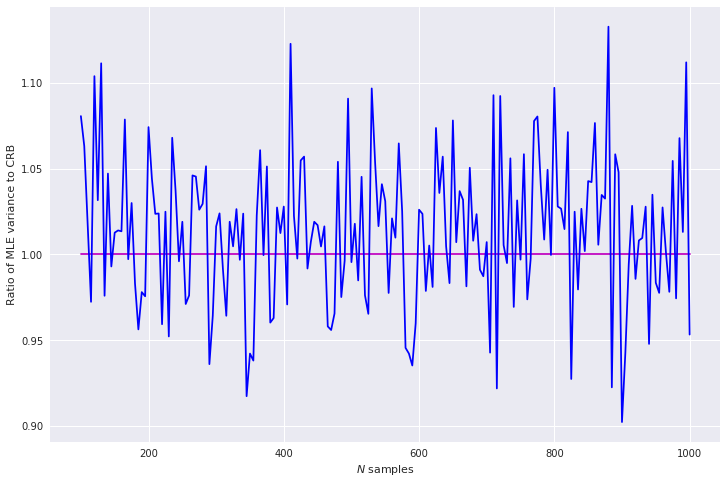

In [52]:
bounds_ratio_plot(0.35, 100, 1000, 5)

Same result in terms of ratio of MLE variance to Cramer-Rao lower bound.

In [54]:
def bounds_deltas_plot(rho, S, N, step, per_it=1000):
    from itertools import product
    plt.figure(figsize=[12, 8])
    deltas=[]
    for i in tqdm_notebook(range(S, N+1, step)):
        MLE=[]
        for j in range(per_it):
            data=simulate_bivariate(rho, i)
            MLE.append(MLE_est(data))
        deltas.append(lower_bound(rho, i)-np.var(MLE))
    rng=list(range(S, N+1, step))
    plt.plot([rng[0], rng[-1]], [0, 0], color='m')
    plt.xlabel('$N$ samples')
    plt.ylabel('CRB-MLE')
    plt.plot(rng, deltas, color='b')

HBox(children=(IntProgress(value=0, max=181), HTML(value='')))

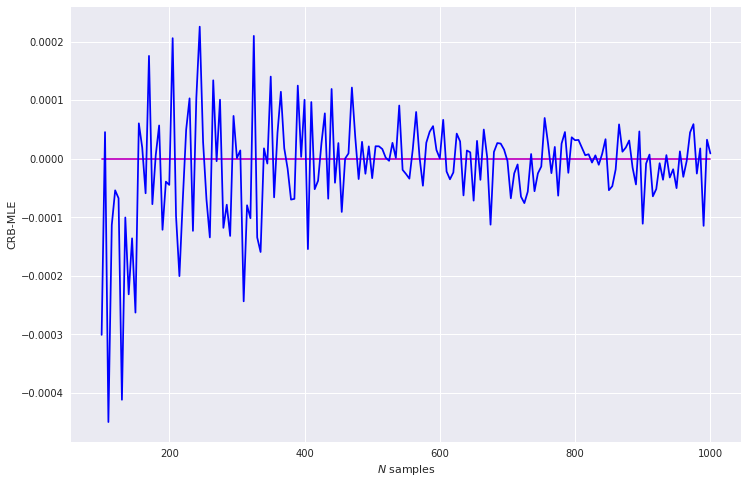

In [55]:
bounds_deltas_plot(0.35, 100, 1000, 5)

Plot for $CRB-var(MLE)$.

# Problem 2

In [19]:
def quotient_est(data):
    return data[:,0].mean()/data[:,1].mean()

def sim_qe(rho, mean, var, S, MAXN, STEP):
    deltas=[]
    for i in range(S, MAXN+1, STEP):
        data=simulate_bivariate(rho, i, mean, var)
        deltas.append(abs(quotient_est(data)-#минус точная оценца Еx/y))
    return est, mean[0]/mean[1], list(range(S, MAXN+1, STEP))

In [12]:
Sample=simulate_bivariate(rho=0.8, N=10000, mean=[1, 2], var=[1, 0.5])

/home/dmitry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


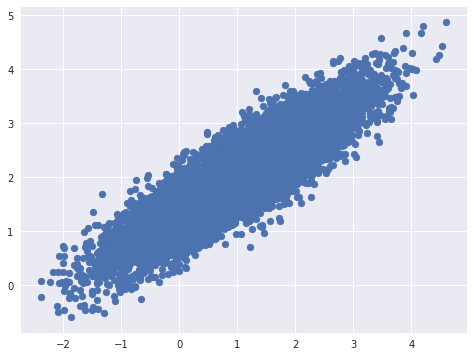

In [13]:
plt.figure(figsize=[8, 6])
plt.scatter(Sample[:, 0], Sample[:, 1])

In [21]:
mean=[1, 2]
ests, true, rng=asymptotic_bias(0.8, mean=[1,2], var=[1, 0.5], S=1000, MAXN=10000, STEP=1)

/home/dmitry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


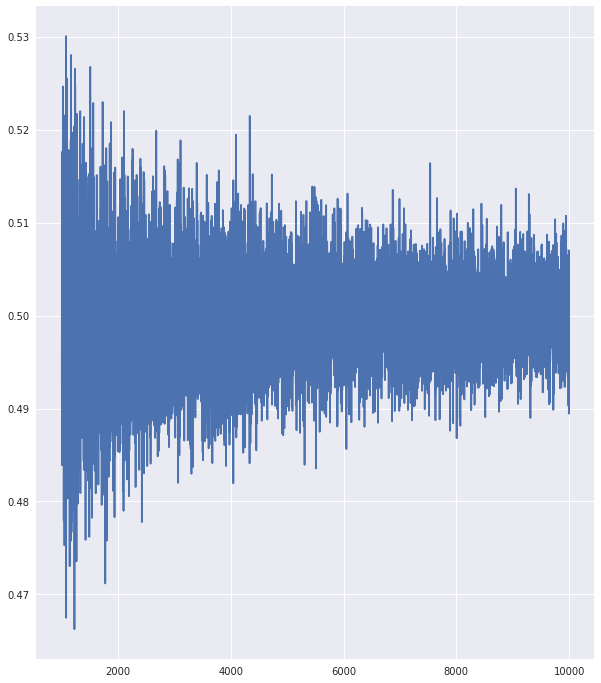

In [26]:
plt.figure(figsize=[10, 12])
plt.plot([rng[0], rng[-1]], [true]*2, color='red')
plt.plot(rng, ests)